In [28]:
from pathlib import Path
from dotenv import load_dotenv
from PIL import Image
import tifffile
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
import torch


warnings.filterwarnings("ignore")
torch.set_default_device('cpu')  # Ensure we use CPU (MPS conflicts on Apple Silicon)
load_dotenv()

from src.models.sam3_model import SAM3Predictor
from src.utils.visualization import display_masks_with_scores, show_sam3_predictions

## Building Segmentation with SAM3

**Context:** We have a dataset with road labels and want to add building locations for better map generation.


For this, we use **SAM3** (Segment Anything with Concepts) from Meta for zero-shot building segmentation via text prompts.

This results in a dataset with one channel for roads and one channel for buildings.

### Sam3 Inference on a single

In [41]:
predictor = SAM3Predictor()

In [42]:
image = Image.open("../data/examples/patches/images/10078660_15_patch_001_x256_y0.png")
prompt = 'building'

masks, boxes, scores = predictor.predict(image, prompt)

In [25]:
road = np.array(Image.open("../data/examples/patches/labels/10078660_15_patch_001_x256_y0.png")).sum(axis=-1)
road = road / road.max()
merged_masks = np.array(
    masks.sum(axis=0).reshape((256, 256)).clip(0,1)
)

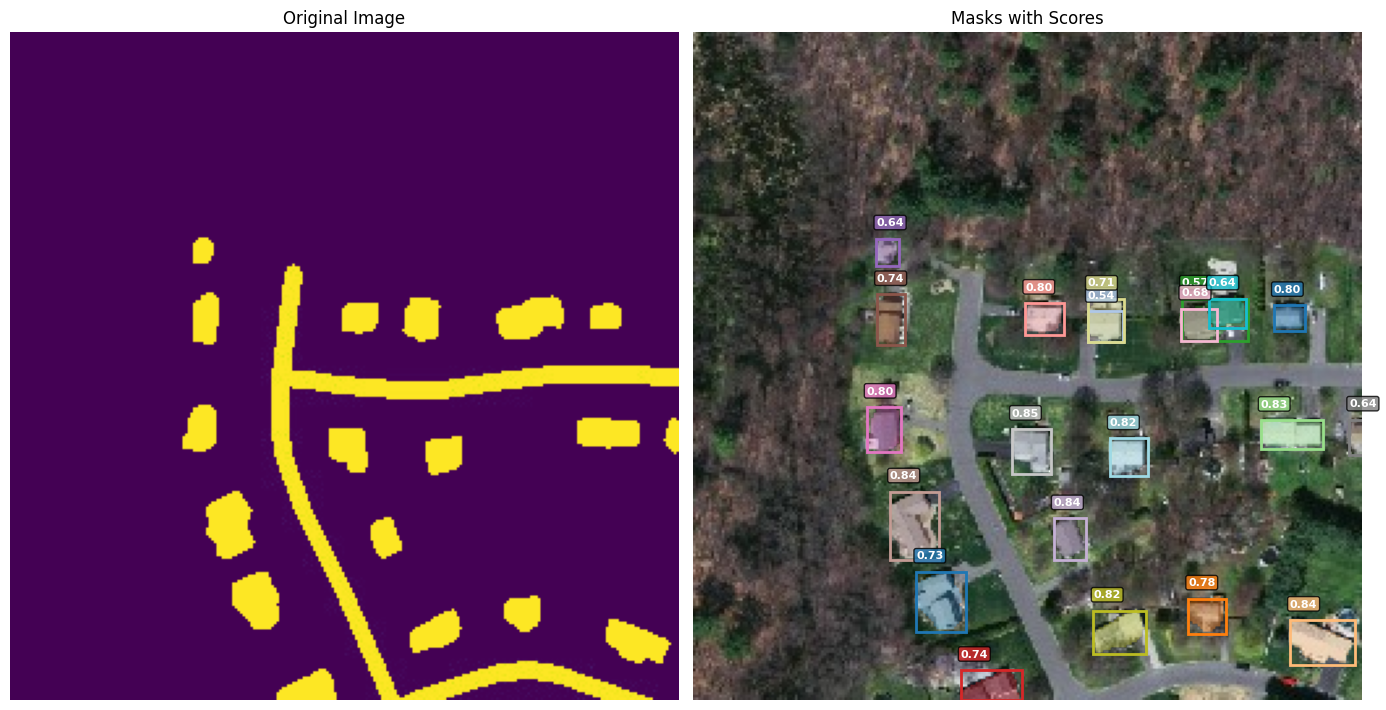

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].imshow(road + merged_masks)
axes[0].set_title('Original Image')
axes[0].axis('off')

display_masks_with_scores(image, masks, boxes, scores, ax=axes[1])
axes[1].set_title('Masks with Scores')
plt.tight_layout()
plt.show()

### Process full training set:

To process the entire training set, we added the `predict_and_process_directory()` method to our `SAM3Predictor` class. In this notebook, we only process the example set (processing the full dataset requires a GPU for faster inference). The entire training set can be processed by running `sam3_model.py`

In [32]:
predictor.predict_and_process_directory(
    directory_path='../data/examples/patches/',
    train_subdir='images',
    label_subdir='labels',
    prompt='building'
)

Processing patches: 100%|██████████| 5/5 [00:00<00:00, 3911.87patch/s]

All set processed!


Results are saved to `../data/examples/sam3_predictions`

In [37]:
base_images_dir = Path('../data/examples/patches/images')
sam3_labels_dir = Path('../data/examples/sam3_predictions')
stems = [img_path.rstrip('.png') for img_path in os.listdir(base_images_dir)]

img2label = {base_images_dir / (stem + '.png'): sam3_labels_dir / (stem + '_processed.tiff') for stem in stems}

In [38]:
train_paths, label_paths = zip(*tuple(img2label.items())[:16])

train_imgs = [Image.open(path)for path in train_paths]
label_imgs = [tifffile.imread(path)for path in label_paths]

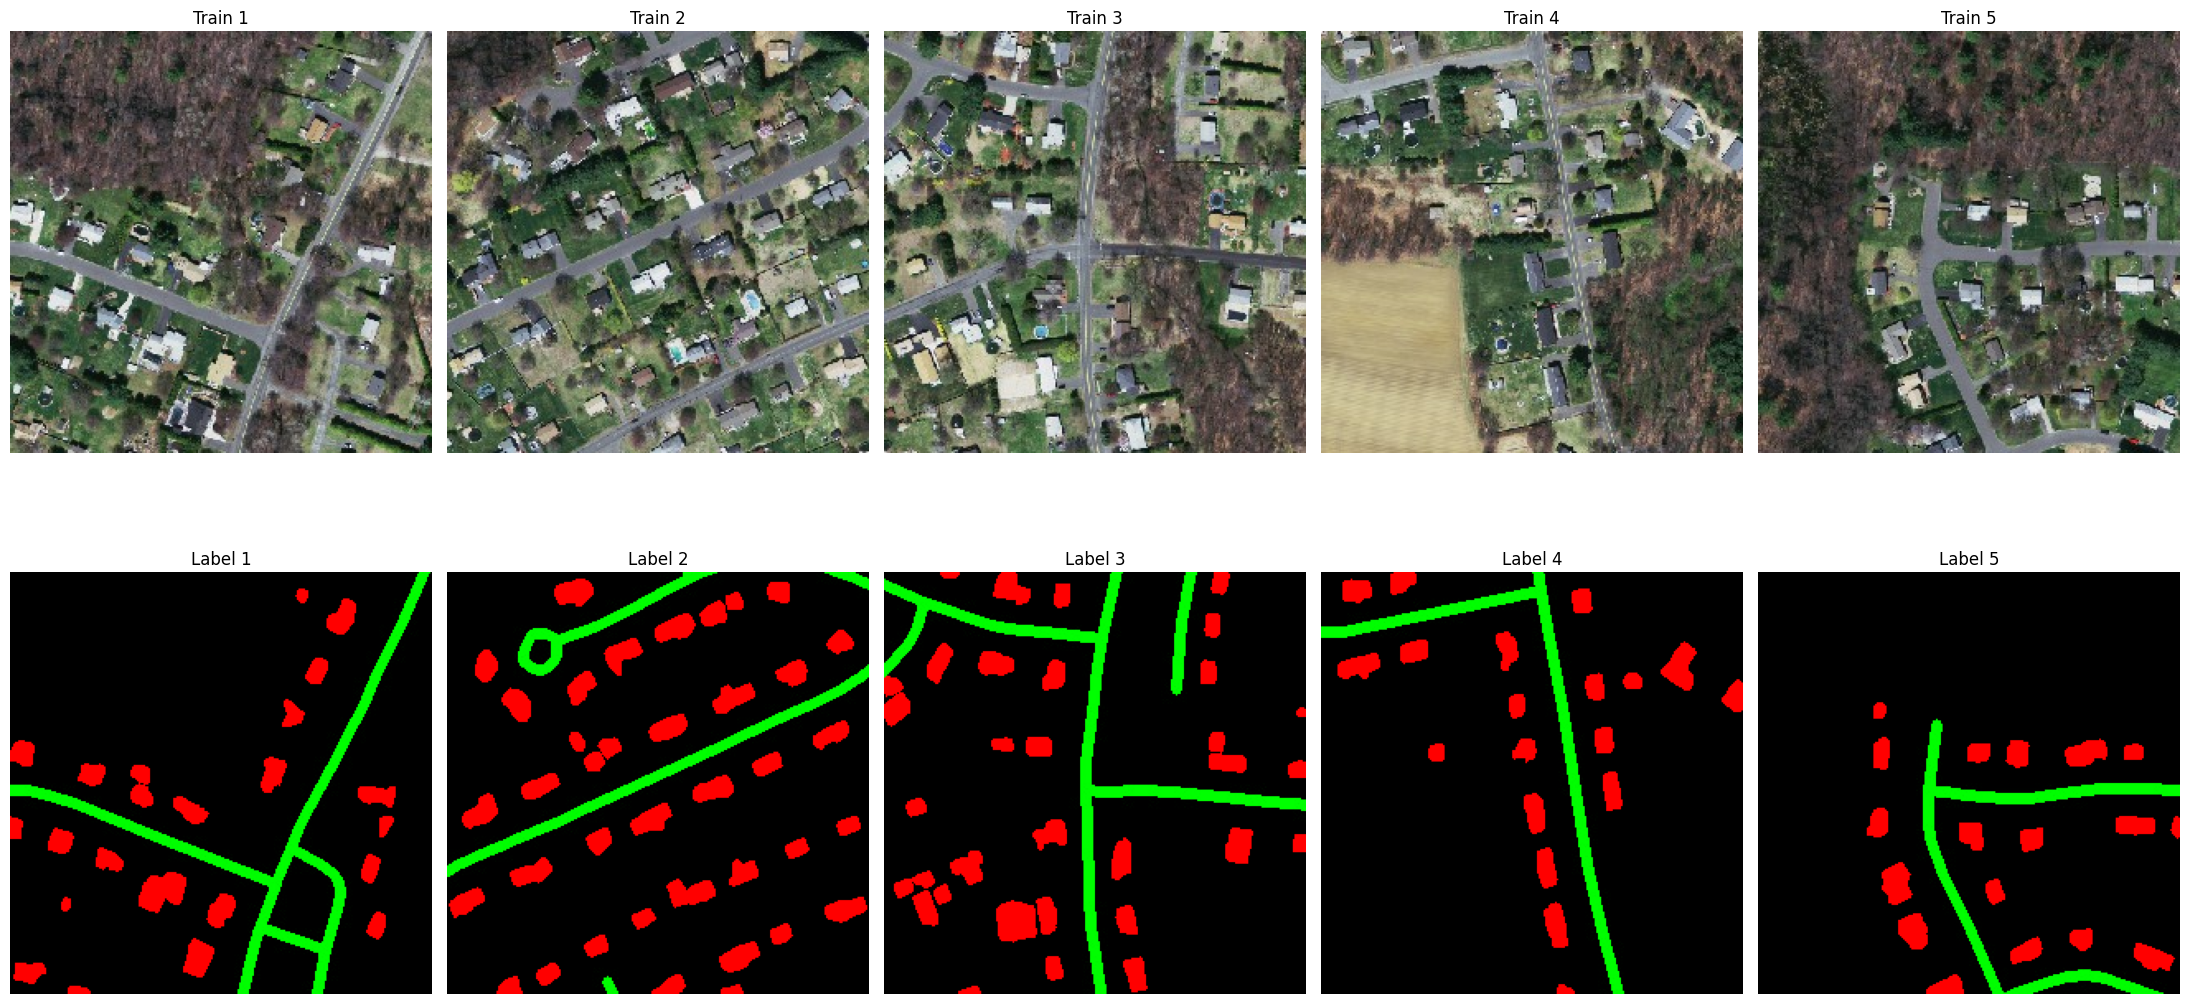

In [40]:
show_sam3_predictions(train_imgs, label_imgs, images_per_row=5, num_sets=1)